In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

pd.set_option('max_row', None)
pd.set_option('max_column', None)


class SinglePeriod:
    def __init__(self,
                 stocks=('AAPL', 'MSFT', 'AAL', 'WMT'),
                 budget=1000,
                 bin_size=None,
                 gamma=None,
                 file_path='',
                 dates=None,
                 model_type='CQM',
                 alpha=0.005,
                 baseline='^GSPC',
                 sampler_args=None,
                 t_cost=0.01,
                 verbose=True,
                 label='PortOpt',
                 init_holdings=None,
                 window_size=1,
                 calculation_type='monthly',
                 initial_date=None,
                 save_path=None):
        
        self.stocks = list(stocks)
        self.budget = budget
        self.init_budget = budget
        self.gamma_list = []
        self.file_path = file_path
        self.dates = dates
        self.model_type = model_type
        self.alpha_list = []
        self.baseline = [baseline]
        self.verbose = verbose
        self.t_cost = t_cost
        self.calculation_type = calculation_type
        self.window_size = window_size
        self.max_num_stocks = 50
        self.save_path = save_path
        if initial_date is not None:
            self.initial_date = initial_date
        else:
            self.initial_date = self.dates[0]

        if init_holdings is not None:
            self.init_holdings = init_holdings
        else:
            self.init_holdings = {s:0 for s in self.stocks}
        self.label = label

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        if gamma:
            if isinstance(gamma, (list, tuple)):
                self.gamma = gamma[-1]
                self.gamma_list = list(gamma)
            elif isinstance(gamma, (int, float)):
                self.gamma = gamma
            else:
                raise TypeError("Use integer or float for gamma, or a list or tuple of either type.")
        else:
            self.gamma = 100

        if bin_size:
            self.bin_size = bin_size
        else:
            self.bin_size = 10

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(sampler_args)
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.solution = {}
        self.precision = 2

    def load_data(self, df=None, num=0):
        if df is not None:
            print("\nLoading data from DataFrame...")
            self.df = df
            self.stocks = df.columns.tolist()
        elif self.file_path is not None:
            print("\nLoading data from provided CSV file...")
            self.df = pd.read_csv(self.file_path, index_col=0)
            for column in self.df.columns:
                if column != 'Date':
                    self.df[column] = self.df[column].astype(np.float32)
                else:
                    self.df[column] = pd.to_datetime(self.df[column])
            self.df_all = self.df.copy()
            
            # Read in baseline data; resample to monthly
            index_df = DataReader(self.baseline, 'yahoo', self.dates[0], self.dates[1])
            if self.calculation_type == 'monthly':
                index_df = index_df.resample('BM').last()
            self.df_baseline = pd.DataFrame(index=index_df.index, columns=self.baseline)
            for i in self.baseline:
                self.df_baseline[i] = index_df[[('Adj Close',  i)]]
        elif self.dates:
            print(f"\nLoading live data from the web from Yahoo! finance", f"from {self.initial_date} to {self.dates[1]}...")

            # Read in daily data; resample to monthly
            panel_data = DataReader(self.stocks, 'yahoo', self.initial_date, self.dates[1])
            if self.calculation_type == 'monthly':
                panel_data = panel_data.resample('BM').last()
            self.df_all = pd.DataFrame(index=panel_data.index, columns=self.stocks)

            for i in self.stocks:
                self.df_all[i] = panel_data[[('Adj Close',  i)]]
            self.df_all.dropna(axis=1, inplace=True)
            self.stocks = self.df_all.columns.values.tolist()

            # Read in baseline data; resample to monthly
            index_df = DataReader(self.baseline, 'yahoo', self.dates[0], self.dates[1])
            
            if self.calculation_type == 'monthly':
                index_df = index_df.resample('BM').last()
            self.df_baseline = pd.DataFrame(index=index_df.index, columns=self.baseline)
            for i in self.baseline:
                self.df_baseline[i] = index_df[[('Adj Close',  i)]]

            self.df = self.df_all
        else:
            print('No data loaded')
            exit()

        print(f'budget: {self.budget}')
        self.max_num_shares = (self.budget/self.df.iloc[-1]).astype(int)
        if self.verbose:
            print("\nMax shares we can afford with a budget of", self.budget)
            print(self.max_num_shares.to_string())

        # For DQM
        self.shares_intervals = {}
        for stock in self.stocks:
            if self.max_num_shares[stock]+1 <= self.bin_size:
                self.shares_intervals[stock] = list(range(self.max_num_shares[stock] + 1))
            else:
                span = (self.max_num_shares[stock]+1) / self.bin_size
                self.shares_intervals[stock] = [int(i*span) for i in range(self.bin_size)]

    def build_cqm(self, max_risk=None, min_return=None, target_date=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        self.price = self.df_all.loc[target_date, :]
        print(f'target date: {target_date}')
        self.daily_returns = self.df_all[list(self.stocks)].pct_change().loc[:target_date, :]
        self.avg_daily_returns = self.df_all[list(self.stocks)].rolling(window=self.window_size-2).mean().dropna()
        self.covariance_matrix = self.daily_returns.loc[:target_date,:].cov()



                   # self.df_all_mod = self.df_all.shift(-1).dropna()

            # for idx in self.avg_daily_returns.index:
            #     sum_q = 0
            #     n_q = 0
            #     for s in self.stocks:
            #         if idx in self.df_all_mod.index:
            #             sum_q += (self.avg_daily_returns.loc[idx, s] - self.df_all_mod.loc[idx, s])**2
            #             n_q += 1
            #             print(f'nq: {n_q} sum_q: {sum_q}')
            
            # #print(f'idx: {idx}, MSE: {sum_q / n_q}')
        
        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        returns = 0
        for s in self.stocks:
            #display(self.avg_daily_returns.loc[target_date, s])
            returns = returns + self.price[s] * self.avg_daily_returns.loc[target_date, s] * x[s]

        # Adding budget and related constraints
        # if not init_holdings:
        #     init_holdings = self.init_holdings
        # else:
        #     self.init_holdings = init_holdings

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')

            # z = {s: Binary("Z[%s]" %s) for s in self.stocks}
            # for s in self.stocks:
            #     cqm.add_constraint(x[s] - 1 * z[s] >= 0)
            #     cqm.add_constraint(x[s] - x[s] * z[s] <= 0)
            # cqm.add_constraint(quicksum([z[s] for s in self.stocks]) <= self.max_num_stocks)

        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0
            # if x <> x0
            # 2 cost price x - 2 cost price x0 <> 0
            # price x - cost price x - price x0 + cost price x0 <> 0
            # if x = x0
            # price x - cost price x - price x0 + cost price x0 = 0
            # 2 cost price x - 2 cost price x0 = 0
            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')

            # z = {s: Binary("Z[%s]" %s) for s in self.stocks}
            # for s in self.stocks:
            #     cqm.add_constraint(x[s] - 1 * z[s] >= 0)
            #     cqm.add_constraint(x[s] - x[s] * z[s] <= 0)
            # cqm.add_constraint(quicksum([z[s] for s in self.stocks]) <= self.max_num_stocks)



        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            cqm.set_objective(self.alpha*risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm

    def solve_cqm(self, max_risk=None, min_return=None, target_date=None):
        self.build_cqm(max_risk, min_return, target_date = target_date)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:        
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'], target_date)
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            #print(f'\nBest feasible solution:')
            #print("\n".join("{}\t{:>3}".format(k, v) for k, v in solution['stocks'].items()))
            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            solution = pd.DataFrame(solution)
            if self.save_path:
                solution.to_pickle(save_path + 'single_period_solution.pkl')
            return solution


    def compute_risk_and_returns(self, solution, date):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        for stock in solution:
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns.loc[date, stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0, num=0):
        """Execute sequence of load_data --> build_model --> solve.
        Args:
            max_risk (int): Maximum risk for the risk bounding formulation.
            min_return (int): Minimum return for the return bounding formulation.
            num (int): Number of stocks to be randomnly generated.
            init_holdings (float): Initial holdings, or initial portfolio state.
        """
        self.load_data(num=num)
        if self.model_type=='CQM':
            print(f"\nCQM run...")
            self.solution['CQM'] = self.solve_cqm(min_return=min_return,
                                                  max_risk=max_risk,
                                            )
        else:
            print(f"\nDQM run...")
            if len(self.alpha_list) > 1 or len(self.gamma_list) > 1:
                print("\nStarting DQM Grid Search...")
                self.dqm_grid_search()

            self.build_dqm()
            self.solution['DQM'] = self.solve_dqm()


In [9]:
class MultiPeriod(SinglePeriod):
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self, stocks=('AAPL', 'MSFT', 'AAL', 'WMT'), budget=1000,
                 bin_size=None, gamma=None, file_path=None,
                 dates=None, model_type='CQM', alpha=0.005, baseline='^GSPC',
                 sampler_args=None, t_cost=0.01, verbose=True, label='Run',
                 init_holdings=None, window_size = 1, calculation_type='monthly', save_path=None):
        """Class constructor.
        Args:
            stocks (list of str): List of stocks.
            budget (int): Portfolio budget.
            bin_size (int): Maximum number of intervals for each stock.
            gamma (float or int or list or tuple): Budget constraint penalty coefficient(s).
                If gamma is a tuple/list and model is DQM, grid search will be done;
                otherwise, no grid search.
            file_path (str): Full path of CSV file containing stock data.
            dates (list of str): Pair of strings for start date and end date.
            model_type (str): CQM or DQM.
            alpha (float or int or list or tuple): Risk aversion coefficient.
                If alpha is a tuple/list and model is DQM, grid search will be done;
                otherwise, no grid search.
            baseline (str): Stock baseline for rebalancing model.
            sampler_args (dict): Sampler arguments.
            t_cost (float): transaction cost; percentage of transaction dollar value.
            verbose (bool): Flag to enable additional output.
        """
        self.window_size = window_size   
        self.save_path = save_path
        n_days = 0
        offset = 0
        self.list_all_dates = []
        while n_days < self.window_size:
            g = (dt.datetime.strptime(dates[0], '%Y-%m-%d') - dt.timedelta(days=x) for x in range(offset))
            self.list_all_dates = [x for x in g if x.weekday() not in (5, 6)]
            n_days = len(self.list_all_dates)
            offset += 1
        self.initial_date = self.list_all_dates[-1]
        

        self.list_dates = [x for x in pd.date_range(dates[0], dates[1], freq='1d').to_pydatetime() if x.weekday() not in (5,6)]
        print(f'initial date: {self.initial_date}')
        print(f'n_days: {n_days}, list dates: {self.list_dates}')

        super().__init__(stocks=stocks,
                         budget=budget,
                         bin_size=bin_size,
                         gamma=gamma,
                         file_path=file_path,
                         dates=dates,
                         model_type=model_type,
                         alpha=alpha,
                         baseline=baseline,
                         sampler_args=sampler_args,
                         t_cost=t_cost,
                         verbose=verbose,
                         label=label,
                         init_holdings=init_holdings,
                         window_size=self.window_size,
                         calculation_type=calculation_type,
                         initial_date = self.initial_date,
                         save_path=self.save_path)

    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """
        self.load_data()

        num_days = len(self.df_all)
        first_purchase = True
        result = {}
        baseline_result = {}
        self.baseline_values = [0]
        self.update_values = [0]
        days = []

        # Define dataframe to save output data
        headers = ['Date', 'Value'] + self.stocks + ['Variance', 'Returns']
        self.opt_results_df = pd.DataFrame(columns=headers)
        row = []

        self.price_df = pd.DataFrame(columns=self.stocks)

        for n, d in enumerate(self.list_dates):
            date = dt.datetime.strftime(d, '%Y-%m-%d')
            self.start_date = dt.datetime.strftime((self.initial_date + dt.timedelta(days=n)), '%Y-%m-%d')
            print(f': n: {n}, date: {date}, start date: {self.start_date}')

            # Look at just the data up to the current month
            df = self.df_all.loc[self.start_date:date, :].copy()
            df.index = pd.to_datetime(df.index)
            baseline_df_current = self.df_baseline.loc[self.start_date:date, :]
            days.append(df.last_valid_index().date())

            if first_purchase:
                budget = self.budget
                initial_budget = self.budget
                baseline_shares = (budget / baseline_df_current.iloc[-1])
                baseline_result = {self.baseline[0]: baseline_shares}
            else:
                # Compute profit of current portfolio
                budget = sum([df.iloc[-1][s]*result['stocks'][s] for s in self.stocks])
                self.update_values.append(budget - initial_budget)

                # Compute profit of fund portfolio
                fund_value = sum([baseline_df_current.iloc[-1][s]*baseline_result[s] for s in self.baseline])
                self.baseline_values.append(fund_value - initial_budget)

                self.budget = budget

            self.load_data(df=df)

            # Output for user on command-line and plot
            update_values = np.array(self.update_values, dtype=object)
            print(update_values)
            baseline_values = np.array(self.baseline_values, dtype=object)

            # Making solve run
            if self.model_type == 'DQM':
                print(f"\nMulti-Period DQM Run...")

                self.build_dqm()
                self.solution['DQM'] = self.solve_dqm()
                result = self.solution['DQM']
            else:
                print(f"\nMulti-Period CQM Run...")

                # Set budget to 0 to enforce that portfolio is self-financing
                if self.t_cost and not first_purchase:
                    self.budget = 0

                self.solution['CQM'] = self.solve_cqm(max_risk=max_risk, min_return=min_return, target_date=date)
                result = self.solution['CQM']
                self.init_holdings = result['stocks']

            result_df = pd.DataFrame(result)
            value = sum([self.price[s]*result['stocks'][s] for s in self.stocks])
            returns = result['return']
            variance = result['risk']


            row = [days[-1].strftime('%Y-%m-%d'), value] + [result['stocks'][s] for s in self.stocks] + [variance, returns]
            self.opt_results_df.loc[n] = row

            first_purchase = False

        #display(self.opt_results_df)
        
        update_values = self.opt_results_df
        print('Values')
        print(update_values['Value'])
        initial_budget = update_values['Value'].values.tolist()[0]
        print(f'initial budget: {initial_budget}')
        update_values['Value2'] = update_values['Value'] / initial_budget - 1
        self.df_baseline.reset_index(inplace=True)
        self.df_baseline['Date'] = self.df_baseline['Date'].dt.strftime('%Y-%m-%d')
        initial_gspc = self.df_baseline.query('Date==@dates[0]').values.tolist()[0][1]
        self.df_baseline.iloc[:,1:] = (self.df_baseline.iloc[:,1:] / initial_gspc - 1)
        fig = plt.figure(figsize=(10.708,8.2))
        sns.scatterplot(x='Date', y='^GSPC', data=self.df_baseline, label='Fund Portfolio')
        sns.scatterplot(x='Date', y='Value2', data=update_values, label='Quantum')
        plt.show()
        print(f'\nRun completed.\n')

        if self.save_path:
            print(self.save_path)
            self.opt_results_df.to_pickle(self.save_path+'opt_results_df.pkl')
            self.df_all.to_pickle(self.save_path+'df_all.pkl')
            self.df_baseline.to_pickle(self.save_path+'df_baseline.pkl')
            update_values.to_pickle(self.save_path+'update_values.pkl')
            #self.daily_returns.to_pickle('daily_returns.pkl')
            #self.avg_daily_returns.to_pickle('avg_daily_returns.pkl')


rebalance: True

Rebalancing portfolio optimization run...
initial date: 2021-05-27 00:00:00
n_days: 4, list dates: [datetime.datetime(2021, 6, 1, 0, 0), datetime.datetime(2021, 6, 2, 0, 0), datetime.datetime(2021, 6, 3, 0, 0), datetime.datetime(2021, 6, 4, 0, 0), datetime.datetime(2021, 6, 7, 0, 0), datetime.datetime(2021, 6, 8, 0, 0), datetime.datetime(2021, 6, 9, 0, 0), datetime.datetime(2021, 6, 10, 0, 0), datetime.datetime(2021, 6, 11, 0, 0), datetime.datetime(2021, 6, 14, 0, 0), datetime.datetime(2021, 6, 15, 0, 0), datetime.datetime(2021, 6, 16, 0, 0), datetime.datetime(2021, 6, 17, 0, 0), datetime.datetime(2021, 6, 18, 0, 0), datetime.datetime(2021, 6, 21, 0, 0), datetime.datetime(2021, 6, 22, 0, 0), datetime.datetime(2021, 6, 23, 0, 0), datetime.datetime(2021, 6, 24, 0, 0), datetime.datetime(2021, 6, 25, 0, 0), datetime.datetime(2021, 6, 28, 0, 0), datetime.datetime(2021, 6, 29, 0, 0), datetime.datetime(2021, 6, 30, 0, 0), datetime.datetime(2021, 7, 1, 0, 0)]

Loading live dat

/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'CEG', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


budget: 1000000
: n: 0, date: 2021-06-01, start date: 2021-05-27

Loading data from DataFrame...
budget: 1000000
[0]

Multi-Period CQM Run...
target date: 2021-06-01
t_cost False
n_samples: 54
solution_stocks: {'MMM': 14, 'AOS': 29, 'ABT': 55, 'ABBV': 20, 'ABMD': 4, 'ACN': 1, 'ATVI': 19, 'ADM': 64, 'ADBE': 0, 'ADP': 9, 'AAP': 12, 'AES': 15, 'AFL': 1, 'A': 15, 'APD': 0, 'AKAM': 11, 'ALK': 74, 'ALB': 1, 'ARE': 3, 'ALGN': 0, 'ALLE': 0, 'LNT': 26, 'ALL': 10, 'GOOGL': 10, 'GOOG': 3, 'MO': 26, 'AMZN': 6, 'AMCR': 58, 'AMD': 17, 'AEE': 12, 'AAL': 21, 'AEP': 2, 'AXP': 13, 'AIG': 3, 'AMT': 4, 'AWK': 41, 'AMP': 10, 'ABC': 6, 'AME': 8, 'AMGN': 21, 'APH': 14, 'ADI': 7, 'ANSS': 13, 'AON': 11, 'APA': 138, 'AAPL': 29, 'AMAT': 20, 'APTV': 5, 'ANET': 60, 'AJG': 3, 'AIZ': 21, 'T': 155, 'ATO': 14, 'ADSK': 11, 'AZO': 11, 'AVB': 18, 'AVY': 3, 'BKR': 21, 'BALL': 40, 'BAC': 3, 'BBWI': 2, 'BAX': 28, 'BDX': 14, 'WRB': 55, 'BBY': 13, 'BIO': 2, 'TECH': 8, 'BIIB': 1, 'BLK': 24, 'BK': 17, 'BA': 1, 'BKNG': 6, 'BWA':

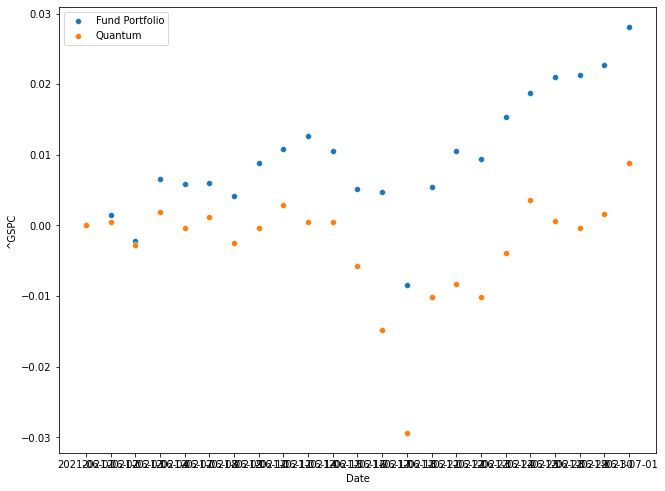


Run completed.

/content/drive/MyDrive/dwave/Run86/
Total time: 16839.116112947464


In [10]:
import time
import yaml

def main(*args, **params):

    max_risk = params['max_risk']
    min_return = params['min_return']
    model_type = params['model_type']
    num = params['num']
    dates = params['dates']

    if ((max_risk or min_return) and model_type != 'CQM'):
        raise Exception("The bound options require a CQM.")

    if (num and not dates):
        raise Exception("User must provide dates with option 'num'.")

    print(f'rebalance: {params["rebalance"]}')

    payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    first_table = payload[0]
    all_stocks = first_table['Symbol'].values.tolist()

    if params["stocks"] is None:
        params["stocks"] = all_stocks

    if not os.path.exists(params['save_path']+params['label']+'/'):
        os.mkdir(params['save_path']+params['label']+'/')

    if params['rebalance']:
        print(f"\nRebalancing portfolio optimization run...")

        my_portfolio = MultiPeriod(stocks=params["stocks"],
                                   budget=params['budget'],
                                   sampler_args=params['sampler_args'],
                                   bin_size=params['bin_size'],
                                   dates=params["dates"],
                                   file_path=params['file_path'],
                                   gamma=params['gamma'],
                                   model_type=params['model_type'],
                                   alpha=params['alpha'],
                                   verbose=params['verbose'],
                                   baseline=params['baseline'],
                                   t_cost=params['t_cost'],
                                   label=params['label'],
                                   init_holdings=params['init_holdings'],
                                   window_size=params['window_size'],
                                   calculation_type=params['calculation_type'],
                                   save_path=params['save_path']+params['label']+'/')
    else:
        print(f"\nSingle period portfolio optimization run...")

        my_portfolio = SinglePeriod(stocks=params['stocks'],
                                    budget=params['budget'],
                                    bin_size=params['bin_size'],
                                    gamma=params['gamma'],
                                    file_path=params['file_path'],
                                    dates=params['dates'],
                                    model_type=params['model_type'],
                                    alpha=params['alpha'],
                                    baseline=params['baseline'],
                                    sampler_args=params['sampler_args'],
                                    t_cost=params['t_cost'],
                                    verbose=params['verbose'],
                                    label=params['label'],
                                    init_holdings=params['init_holdings'],
                                    window_size=params['window_size'],
                                    calculation_type=params['calculation_type'],
                                    initial_date = None,
                                    save_path=params['save_path']+params['label']+'/')

    my_portfolio.run(min_return=min_return, max_risk=max_risk, num=num)

if __name__ == '__main__':
    # with open('config.yml', 'r') as yml:
    #     cfg = yaml.safe_load(yml)
    #     locals().update(cfg)
    load_path = '/content/drive/MyDrive/dwave/conf/'
    with open(load_path+'config.txt', 'r') as conf:
        cred = conf.readline().strip()
    cfg = {'stocks': None,
           'dates': ["2021-06-01", "2021-07-01"],
            'budget': 1000000,
            'bin_size': '',
            'gamma': '',
            'alpha': 0.0005,
            'file_path': None,
            'baseline': '^GSPC',
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.00,
            'label': 'Run87',
            'init_holdings': None,
            'window_size': 4,
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
        }
    locals().update(cfg)
    t1 = time.time()
    main(**locals())
    t2 = time.time()
    print(f'Total time: {t2-t1}')
